In [1]:
import numpy as np
import torch
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from ml import BrainDataset, PolicyEstimator, reinforce
from cust_plot import plot

In [2]:
# Input Parameters
num_fns = 8
save_path = None
load_path = None
res = 68
subj = [0]
epochs = 1
batch = 1
hidden_units = 2000
lr = 0.005
save_path = None
load_path = None

In [3]:
# Read brain data (change file locations as necessary)
sc = loadmat(f'data/subjfiles_SC{res}.mat')
fc = loadmat(f'data/subjfiles_FC{res}.mat')
sc = np.array([sc[f's{str(z+1).zfill(3)}'] for z in subj])
fc = np.array([fc[f's{str(z+1).zfill(3)}'] for z in subj])
euc_dist = loadmat('data/euc_dist.mat')[f'eu{res}']
hubs = np.loadtxt(f'data/hubs_{res}.txt', dtype=np.int, delimiter=',')
regions = np.loadtxt(f'data/regions_{res}.txt', dtype=np.int, delimiter=',')

In [4]:
# Init network parameters
pe = PolicyEstimator(res, num_fns)
opt = torch.optim.Adam(pe.network.parameters(), lr=lr)

In [5]:
# Init new/load previous training data
if load_path:
    # Load from checkpoint
    checkpoint = torch.load(load_path)
    plt_data = {k: checkpoint[k] for k in ('rewards','success','mu','sig','train_idx','test_idx')}
    pe.network.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    # New
    plt_data = {
        'rewards': [],
        'success': [],
        'mu': [[] for _ in range(num_fns)],
        'sig': [[] for _ in range(num_fns)]}
    plt_data['train_idx'], plt_data['test_idx'] = train_test_split(subj, train_size=0.7) if len(subj) > 1 else (subj, [])

In [6]:
# Train / test split
train_idx, test_idx = plt_data['train_idx'], plt_data['test_idx']
train_data = BrainDataset(sc[train_idx], fc[train_idx], euc_dist, hubs, regions)
test_data =  BrainDataset(sc[test_idx],  fc[test_idx],  euc_dist, hubs, regions)

In [7]:
# Reinforce part 1: Sampling to make a fast start
print('Part 1: Fast start (sampling)...')
edge_count = res * (res - 1)
e_max = int(np.log2(edge_count))
s_max = 2 ** e_max
e = s_max
s = 1
while True:
    for _ in range(2):
        reinforce(pe, opt, train_data, epochs=e, batch=batch, sample=s, lr=lr, plt_data=plt_data)
    s *= 2
    e = int(e / 2)
    if s > s_max:
        break

# Reinforce Part 2: Running on full brain
print('Part 2: Full brain...')
reinforce(pe, opt, train_data, epochs=epochs, batch=batch, lr=lr, plt_data=plt_data)

Part 1: Fast start (sampling)...
Part 2: Full brain...


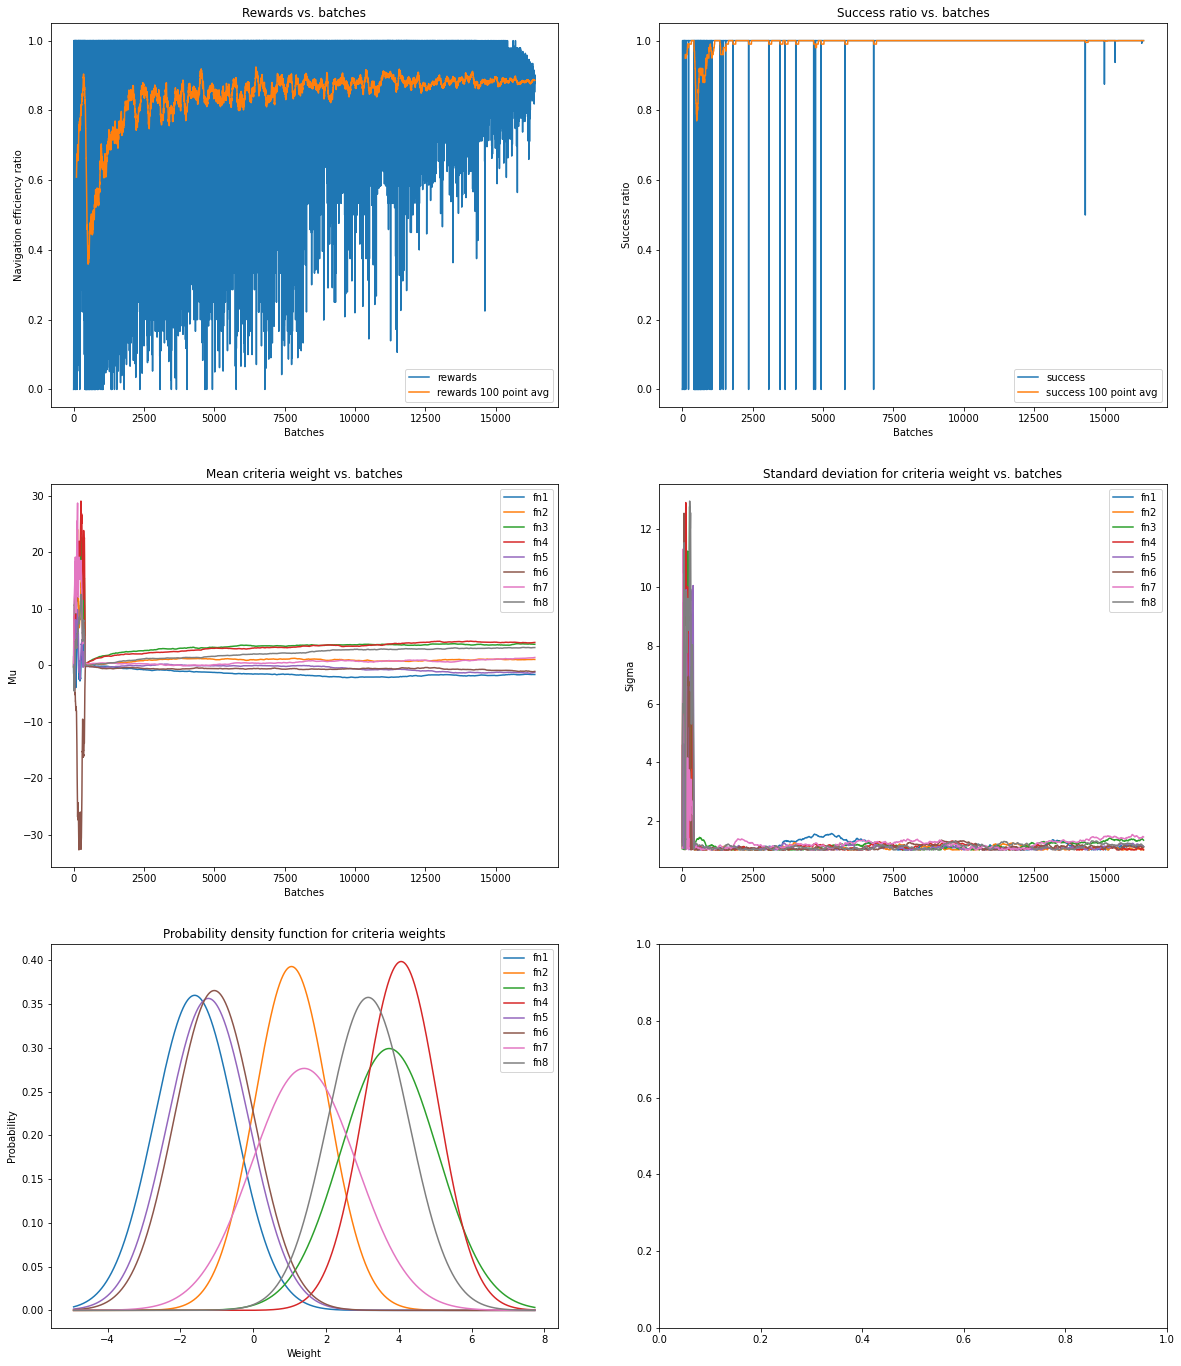

In [8]:
# Visualise training
plot(plt_data, num_fns=num_fns, plt_avg=100)

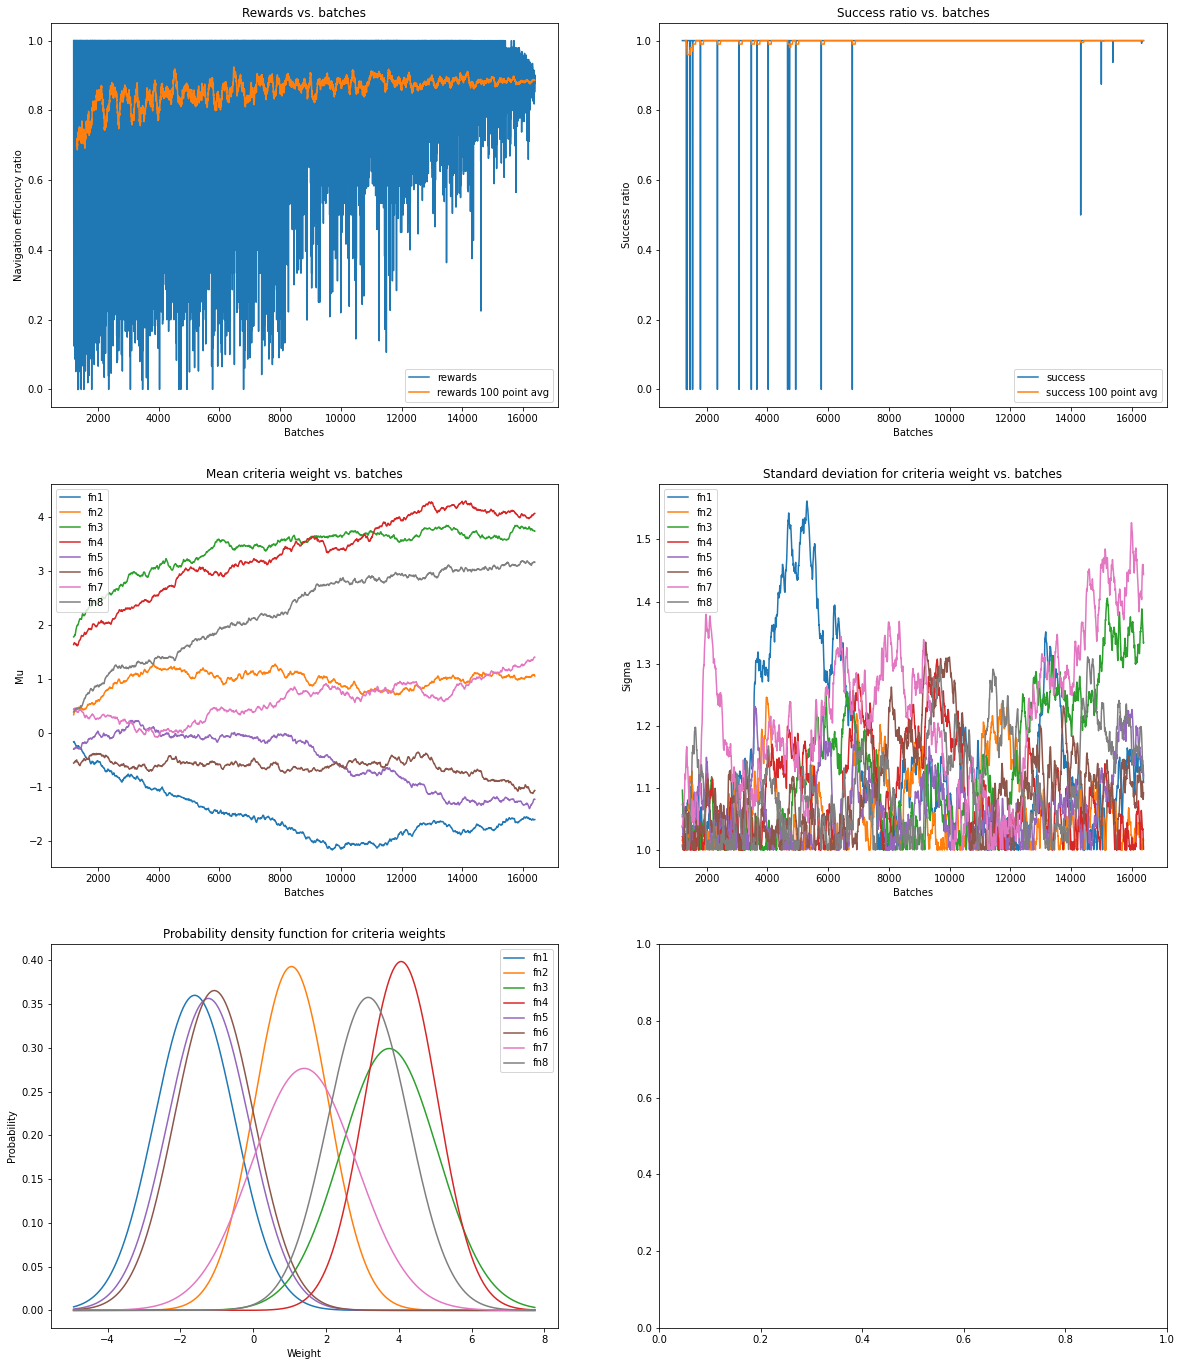

In [9]:
plot(plt_data, num_fns=num_fns, plt_off=1200, plt_avg=100)

In [10]:
# Recent rewards
plt_data['rewards'][-3:]

[0.9004241824150085, 0.8789403438568115, 0.8887014389038086]